In [ ]:
import sys
from pathlib import Path

path_to_your_local_folder = Path("/Users/marco/Work-MBP/gtfs_railways")
#path_to_your_local_folder = Path("C:/Users/KIIT/Documents/UAntwerp/railways_resilience")
sys.path.append(str(path_to_your_local_folder))

from utils.imports import *

In [27]:
from config import PATH_TO_SQLITE, GRAPHS_DIR
attributes = load_gtfs(str(PATH_TO_SQLITE))
L_graph = load_graph(L_SPACE_PATH)

Importing gtfs zip from file /Users/marco/Work-MBP/railways_resilience/data/sqlite/belgium.sqlite


In [28]:
from gtfs_railways.functions.core import simulate_fixed_node_removal_efficiency


In [29]:
subgraph = load_graph(DATA_DIR / "pkl" / "belgium" / "patterns" / "ring" / "graph_0.pkl")
output_path = GRAPHS_DIR / "belgium" / "patterns" / "ring.png"
os.makedirs(GRAPHS_DIR / "belgium" / "patterns", exist_ok=True)

plot_graph(subgraph, back_map="OSM")

In [30]:
import matplotlib.pyplot as plt

# Define methods to compare
methods = {
    "Random (Average)": "random_average",
    "Targeted Most Important": "targeted",
    "Targeted Least Important": "targeted_least"
}

# Define removal types
removal_types = [
    "node",
    "edge"
]

# Prepare storage for all results
results = {rtype: {} for rtype in removal_types}

# Shared shortest-path function
sp_func = make_sp_func(attributes, get_all_GTC_v4, P_space_v4)

# Main loop: iterate over removal types and methods
for rtype in removal_types:
    print(f"\n=== Running {rtype.upper()} REMOVALS ===")
    for label, method in methods.items():
        print(f"\n--- {label} ---")
        results[rtype][label] = {}
        if method == "random_average":
            # Use the modified function for random average
            if rtype == "node":
                orig_eff, mean_eff, std_eff, pct = random_node_removal_average(
                    L_graph=subgraph,
                    G=subgraph.copy(),
                    num_to_remove=subgraph.number_of_nodes(),
                    sp_func=sp_func,
                    n_runs=10,
                    verbose=False
                )
            else:  # edge removal
                orig_eff, mean_eff, std_eff, pct = random_edge_removal_average(
                    L_graph=subgraph,
                    G=subgraph.copy(),
                    num_to_remove=subgraph.number_of_edges(),
                    sp_func=sp_func,
                    n_runs=10,
                    verbose=False
                )

            results[rtype][label]['pct'] = pct
            results[rtype][label]['mean_eff'] = mean_eff
            results[rtype][label]['std_eff'] = std_eff

        else:
            # Standard single-run simulation
            original_eff, effs, pct, removed, times = simulate_fixed_node_removal_efficiency(
                L_graph=subgraph,
                sp_func=sp_func,
                pct_to_remove=100,
                removal_type=rtype,
                method=method,
                seed=42,
                verbose=False
            )

            print(f"saving  {rtype}/{label} into resutls")
            results[rtype][label]['pct'] = pct
            results[rtype][label]['effs'] = effs

print(f"============= DONE =============")


=== Running NODE REMOVALS ===

--- Random (Average) ---
Function 'random_node_removal_average' completed.
Execution time: 6.08 seconds


--- Targeted Most Important ---
Function 'simulate_fixed_node_removal_efficiency' completed.
Execution time: 11.22 seconds

saving  node/Targeted Most Important into resutls

--- Targeted Least Important ---
Function 'simulate_fixed_node_removal_efficiency' completed.
Execution time: 30.72 seconds

saving  node/Targeted Least Important into resutls

=== Running EDGE REMOVALS ===

--- Random (Average) ---
Function 'random_edge_removal_average' completed.
Execution time: 8.53 seconds


--- Targeted Most Important ---
Function 'simulate_fixed_node_removal_efficiency' completed.
Execution time: 16.08 seconds

saving  edge/Targeted Most Important into resutls

--- Targeted Least Important ---
Function 'simulate_fixed_node_removal_efficiency' completed.
Execution time: 32.89 seconds

saving  edge/Targeted Least Important into resutls
============= DONE ===

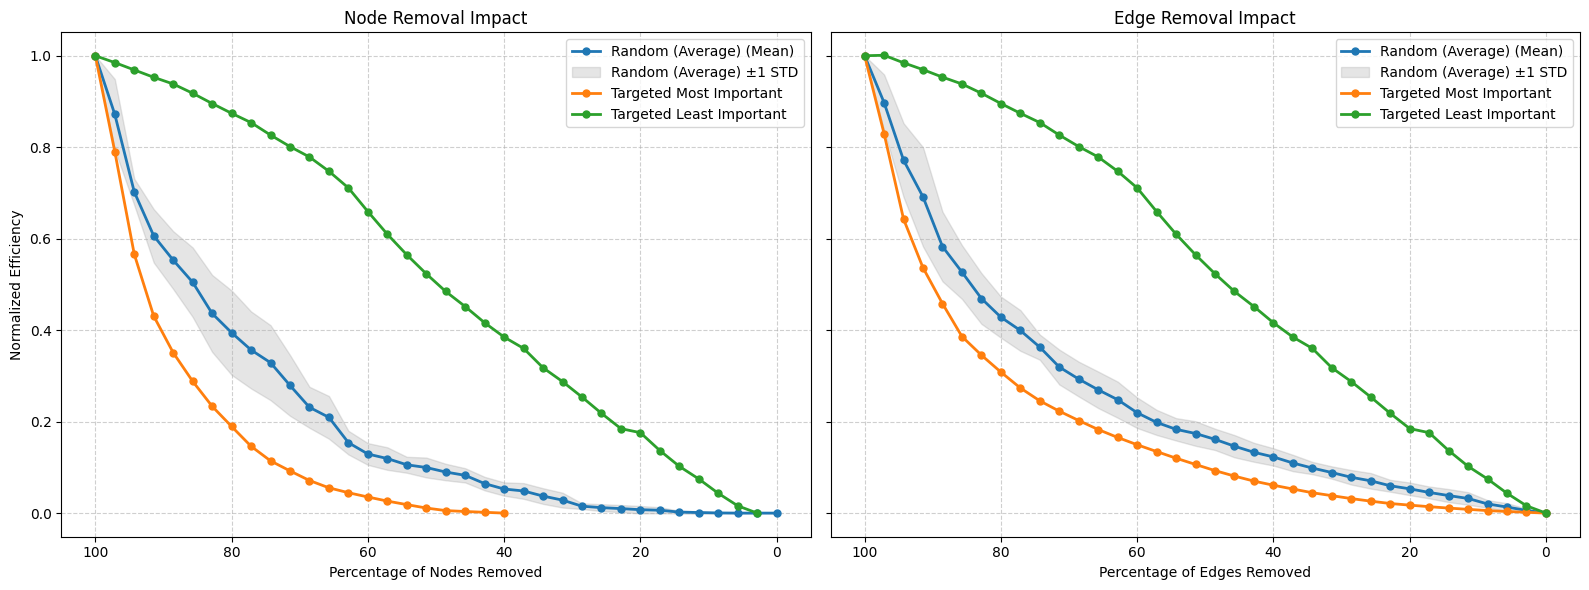

In [31]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey = True )

for i, rtype in enumerate(removal_types):
    ax = axes[i]
    for label, method in methods.items():

        if label == "Random (Average)":
            pct = results[rtype][label]['pct']
            mean_eff = results[rtype][label]['mean_eff']
            std_eff = results[rtype][label]['std_eff']

            ax.plot(pct, mean_eff, marker='o', label=f"{label} (Mean)", linewidth=2, markersize=5)
            ax.fill_between(pct, mean_eff - std_eff, mean_eff + std_eff,
                            color='gray', alpha=0.2, label=f"{label} ±1 STD")
        else:
            pct = results[rtype][label]['pct']
            effs = results[rtype][label]['effs']

            ax.plot(pct, effs, marker='o', label=label, linewidth=2, markersize=5)

    ax.set_xlabel(f"Percentage of {rtype.capitalize()}s Removed")
    ax.set_title(f"{rtype.capitalize()} Removal Impact")
    ax.invert_xaxis()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

axes[0].set_ylabel("Normalized Efficiency")
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define models
def exponential(x, a, b, c): return a * np.exp(-b * x) + c
def logistic(x, a, b, c): return a / (1 + np.exp(b * (x - c)))
def stretched_sigmoid(x, a, b, c): return a / (1 + np.exp(b * (x - c)))
def stretched_power(x, a, b, c): return a * np.power(np.clip(1 - x, 1e-6, None), b) + c
def beta_like(x, a, alpha, beta):
    x = np.clip(x, 1e-6, 1 - 1e-6)
    return a * (x**alpha) * ((1 - x)**beta)

model_formulas = {
        "Exponential": "y = a * exp(-b * x) + c",
        "Logistic": "y = a / (1 + exp(b * (x - c)))",
        "Stretched Sigmoid": "y = a / (1 + exp(b * (x - c)))",
        "Stretched Power": "y = a * (1 - x)^b + c",
        "Beta-like": "y = A * x^alpha * (1 - x)^beta"
    }

all_models = {
        "Exponential": (exponential, [1, 3, 0]),
        "Logistic": (logistic, [1, 10, 0.5]),
        "Stretched Sigmoid": (stretched_sigmoid, [1, 10, 0.5]),
        "Stretched Power": (stretched_power, [1, 2, 0]),
        "Beta-like": (beta_like, [1, 1, 3])
    }


In [33]:
from sklearn.metrics import r2_score

def find_best_fit(
        removal_scope="node",
        removal_type="Targeted Most Important",
        models_to_use=None,
        verbose=False
        ):

    """
    Fits and visualizes efficiency degradation curves for a given network removal type and scope.
    Generates two side-by-side plots:
        (1) Data + all model fits (discrete points)
        (2) Data + best-fit model with continuous smooth curve
    Returns: dict with best model name, formula, coefficients, and R².
    """
    def log(msg):
        if verbose:
            print(msg)

    log(f"Find best fit for: {removal_scope} removal - {removal_type}")
    if results is None:
        raise ValueError("You must pass the results dictionary.")

    # Select removal data
    if removal_type in [ "Targeted Most Important", "Targeted Least Important" ]:
        x_raw = results[removal_scope][removal_type]['pct']
        y = results[removal_scope][removal_type]['effs']

    elif removal_type == "Random (Average)":
        x_raw = results[removal_scope][removal_type]['pct']
        y = results[removal_scope][removal_type]['mean_eff']

    else:
        raise ValueError(f"Invalid removal_type: {removal_type}.")

    # Normalize x
    x = np.array(x_raw) #/ np.max(x_raw)
    y = np.array(y)

    if models_to_use:
        models = {m: all_models[m] for m in models_to_use if m in all_models}
    else:
        models = all_models

    # Fit models
    best_model, best_r2, best_func, best_params = None, -np.inf, None, None

    all_fits = {}
    for name, (func, p0) in models.items():
        all_fits[name] = {
            'params' : None,
            'r2' : None,
            'y_fit' : None,
            'x_fit' : x
            }

        try:
            log(f"fitting model: {name}")
            popt, pcov = curve_fit(func, x, y, p0=p0, maxfev = 1000 )
            y_fit = func(x, *popt)

            r2 = r2_score(y, y_fit)
            log(f"    R²: {r2:.4f}")

            all_fits[name]['params'] = popt
            all_fits[name]['r2'] = r2
            all_fits[name]['y_fit'] = y_fit

            if r2 > best_r2:
                log(f"    best model found: {best_model}, Rˆ2={best_r2}")
                all_fits['best_model'] = {
                    "best_model": name,
                    "coefficients": popt.tolist(),
                    "r2": r2,
                    }

        except RuntimeError:
            log(f"    fitting failed for model: {name}")
            continue

    return all_fits


In [34]:
# Fit NODE removal curve
from pprint import pprint
# example usage


node_best = find_best_fit(
    removal_scope="edge",
    removal_type="Targeted Most Important",
    models_to_use=["Exponential", "Logistic", "Stretched Power", "Stretched Sigmoid", "Beta-like"],
)

pprint(node_best)


{'Beta-like': {'params': array([ 0.72031943,  3.46840576, -0.02447   ]),
               'r2': 0.9819107864555604,
               'x_fit': array([1.        , 0.97142857, 0.94285714, 0.91428571, 0.88571429,
       0.85714286, 0.82857143, 0.8       , 0.77142857, 0.74285714,
       0.71428571, 0.68571429, 0.65714286, 0.62857143, 0.6       ,
       0.57142857, 0.54285714, 0.51428571, 0.48571429, 0.45714286,
       0.42857143, 0.4       , 0.37142857, 0.34285714, 0.31428571,
       0.28571429, 0.25714286, 0.22857143, 0.2       , 0.17142857,
       0.14285714, 0.11428571, 0.08571429, 0.05714286, 0.02857143,
       0.        ]),
               'y_fit': array([1.01005177e+00, 7.10631208e-01, 6.29956078e-01, 5.60595588e-01,
       4.98619271e-01, 4.42594538e-01, 3.91743912e-01, 3.45545849e-01,
       3.03602743e-01, 2.65586120e-01, 2.31210289e-01, 2.00218277e-01,
       1.72373731e-01, 1.47455964e-01, 1.25256780e-01, 1.05578371e-01,
       8.82318769e-02, 7.30363869e-02, 5.98182339e-02, 4.8410499

In [35]:
for rtype in removal_types:
    print(f"\n=== Running {rtype.upper()} REMOVALS ===")
    for label, method in methods.items():
        print(label,'-', method,'-', rtype)
        results[rtype][label]['all_fits'] = find_best_fit(
            removal_scope=rtype,
            removal_type=label,
            models_to_use=["Exponential", "Logistic", "Stretched Power", "Stretched Sigmoid", "Beta-like"],
            )
        pprint(results[rtype][label]['all_fits']['best_model'])



=== Running NODE REMOVALS ===
Random (Average) - random_average - node
{'best_model': 'Beta-like',
 'coefficients': [0.8489120770835344, 3.444300897859072, -0.012212849539550534],
 'r2': 0.9954819451042524}
Targeted Most Important - targeted - node
{'best_model': 'Beta-like',
 'coefficients': [0.8832332446056038,
                  7.2598866126590575,
                  -0.009170226795962617],
 'r2': 0.9955699247139405}
Targeted Least Important - targeted_least - node
{'best_model': 'Beta-like',
 'coefficients': [1.1276014100954228, 1.1330663731954604, 0.0104382082975168],
 'r2': 0.9921269167617177}

=== Running EDGE REMOVALS ===
Random (Average) - random_average - edge
{'best_model': 'Beta-like',
 'coefficients': [0.8035142975200614,
                  2.4950929640443547,
                  -0.016857091966438274],
 'r2': 0.9810668084105437}
Targeted Most Important - targeted - edge
{'best_model': 'Beta-like',
 'coefficients': [0.7203194314868855,
                  3.4684057552300787,
   

/var/folders/61/p8_c17jx5_b1fp37l37jg9l40000gn/T/ipykernel_33240/4106578405.py:13: RuntimeWarning: overflow encountered in power
  return a * (x**alpha) * ((1 - x)**beta)


22 22
22 22


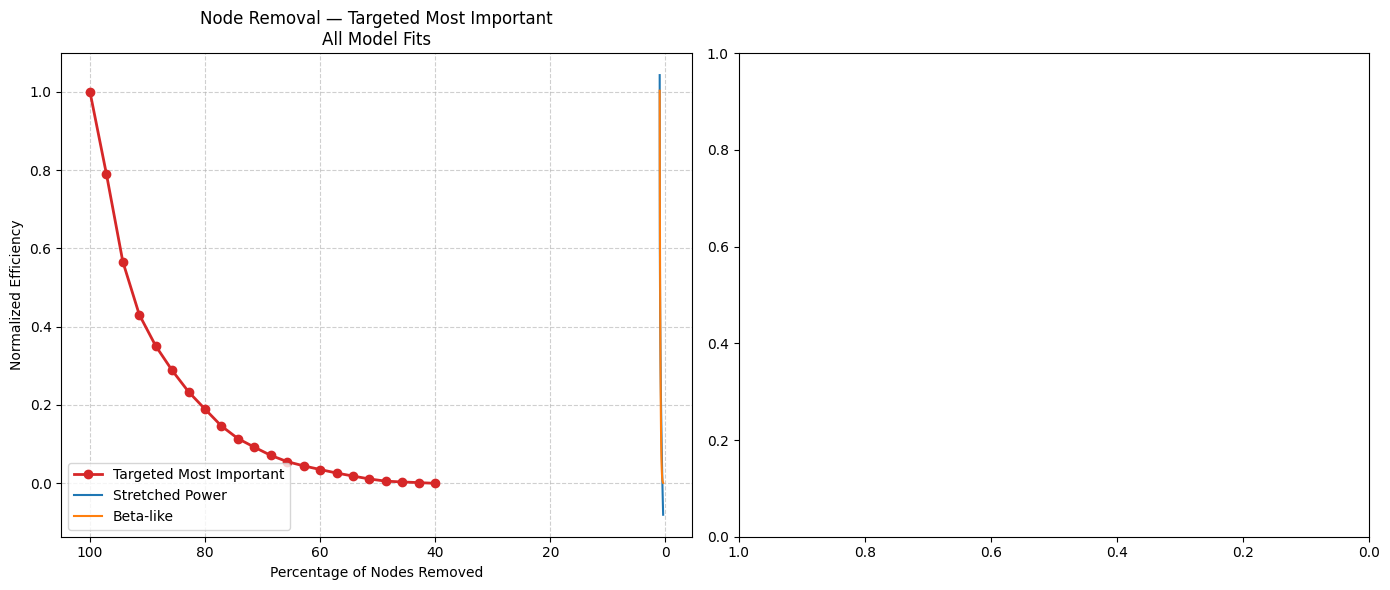

In [41]:
def plot_all_fits(
        results,
        removal_scope="node",
        removal_type="Targeted Most Important",
):


    data = results[removal_scope][removal_type]

    x_raw = data["pct"]
    y_raw = data["effs"] if removal_type != "Random (Average)" else data["mean_eff"]

    # Plotting
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6))
    ax1.invert_xaxis()
    ax2.invert_xaxis()

    ax1.plot(x_raw, y_raw, "o-", color="tab:red", linewidth=2, label=f"{removal_type}")

    for name in all_models.keys():

        reuslts_values = data['all_fits'][name]
        if reuslts_values['params'] is None:
            pass
        else :

            x_fit = data['all_fits'][name]['x_fit']
            y_fit = data['all_fits'][name]['y_fit']
            print(len(x_fit), len(y_fit))
            ax1.plot(x_fit, y_fit, "-", label=name)

    ax1.set_title(f"{removal_scope.capitalize()} Removal — {removal_type}\nAll Model Fits")
    ax1.set_xlabel(f"Percentage of {removal_scope.capitalize()}s Removed")
    ax1.set_ylabel("Normalized Efficiency")
    ax1.grid(True, linestyle="--", alpha=0.6)
    ax1.legend()
    '''

    #plot best model
    ax2.plot(x_raw, y, "o-", color="tab:red", linewidth=2, label=f"Data: {removal_type}")
    x_dense = np.linspace(min(x_raw), max(x_raw), 300)
    x_dense_norm = x_dense / np.max(x_raw)
    y_dense = best_func(x_dense_norm, *best_params)
    ax2.plot(x_dense, y_dense, color="grey", linewidth=2.5,
                 label=f"Best Fit: {best_model}\nR²={best_r2:.3f}\nParams={np.round(best_params, 3)}")

    ax2.set_title(f"Best Fit Model Only ({best_model})")
    ax2.set_xlabel(f"Percentage of {removal_scope.capitalize()}s Removed")
    ax2.grid(True, linestyle="--", alpha=0.6)
    ax2.legend()

    '''

    plt.tight_layout()
    plt.show()


plot_all_fits(results)

In [1]:
x_raw

NameError: name 'x_raw' is not defined